# Goal: use a temporal difference learning algorithm (a RL) to model trial-by-trial behavior of each subject and evaluate how well this algorithm captures the behavioral variations across subjects
1. Write a function to return trial-by-trial conflict prediction based on a given conflict sequence and a given learning rate(alpha) 
2. Determine which combination of learning rates (a learning model) that describe a subject's behavior best
3. Estimate how well the PE_face/PE_name accounts for the variance in RT (among other factors) for each subject
4. Evaluate how well the model fitting procedure accounts for the variance in the group-level behavioral effects

In [1]:
import pandas as pd
import numpy as np

* Load in the data from a csv file

In [2]:
colNames = ['sbjId','faceId','nameId','conflict','zRT','RT']
df_group = pd.read_csv('ISPC_behavior.csv', header=0, names=colNames)
print(df_group.shape)
np.unique(df_group.sbjId)

(19488, 6)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

* The following analysis should loop through each subject to obtain the best fitting learning rates

In [3]:
#for S in np.unique(df_group.sbjId):
S = 1
df = df_group.loc[df_group.sbjId==S,:]
df.head()

,sbjId,faceId,nameId,conflict,zRT,RT
0,1,8,8,0,-0.240255,577.219800
1,1,5,5,0,0.820208,665.302282
2,1,7,6,1,2.027002,765.539121
3,1,5,6,1,2.946576,841.919275
4,1,8,7,1,-0.230702,578.013324


* The idea is to use subjects' behavior (response time, df.RT) and the given conflict-level trial sequence (df.conflict) to infer their learning rates
* To do so, we'll apply a simple temporal difference learning [or a reinforcement learning] algorithm (Sutton & Barto, 1998) because we assume that's how subjects learn to predict each trial's conflict-level 
* We will exhaustively search for the learning rates that best describe subjects' behavior (RT)

# 1. Write a function to return trial-by-trial conflict prediction based on a given conflict sequence and a given learning rate(alpha)

In [4]:
def conflictPred(c,alpha):
    c=np.array(c)
    p = np.zeros(len(c))+0.5
    for i in range(len(c)-1):
        p[i+1] = p[i]+ alpha*(c[i]-p[i])
    return p

* There are two potential sources of conflict prediction: from face stimuli and from name stimuli
* In the Stroop task - subjects see a face with overlapping name (this name could be that face's name [conflict level=0] or someone else's name [conflict level =1])
* Subjects only need to pay attention to the face to do the task, but the name could be helpful (e.g., if it is that face's name)
* We design the task such that in one condition, face information is predictive of the conflict-level and in another conditoin, name information is predictive of the conflict-evel
* We want to know- whether subjects use face/name information to predict trial-by-trial conflict-level and facilitate their task performance

In [6]:
alpha_face = 0.01
alpha_name = 0.01
df.is_copy = False
for i in range(0,8,1):  # 0-7 (8 unique ids)
    df.loc[df.faceId==i+1,'CP_face'] = conflictPred(df.loc[df.faceId==i+1, 'conflict'], alpha_face)
    df.loc[df.nameId==i+1,'CP_name'] = conflictPred(df.loc[df.nameId==i+1, 'conflict'], alpha_name)
df.head()            

,sbjId,faceId,nameId,conflict,zRT,RT,CP_face,CP_name
0,1,8,8,0,-0.240255,577.219800,0.500,0.500
1,1,5,5,0,0.820208,665.302282,0.500,0.500
2,1,7,6,1,2.027002,765.539121,0.500,0.500
3,1,5,6,1,2.946576,841.919275,0.495,0.505
4,1,8,7,1,-0.230702,578.013324,0.495,0.500


# 2. Determine which combination of learning rates (a learning model) that describe a subject's behavior best
- Calculate the sume of squared errors (SSEs) for each combination of alpha_face and alpha_name
- Find the smallest SSEs

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

* For each pair of learning rates (alpha_face and alpha_name):
* Construct the design matrix 
* Regress against **RT** to evaluate this particular learning model
* Calculate the Sum of Squared Errors (**SSEs**)

4264115.94272


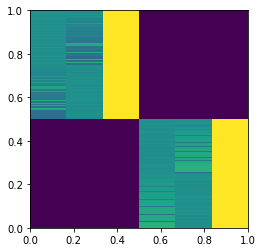

In [8]:
idxC = df[(df.conflict==0) & (df.zRT.notnull())].index
idxI = df[(df.conflict==1) & (df.zRT.notnull())].index
RT = np.concatenate((np.array(df.loc[idxC,'RT']), np.array(df.loc[idxI,'RT'])), axis=0)
constC = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxC),dtype=int))
constI = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxI),dtype=int))
#
dmC = df.loc[idxC,['CP_face','CP_name']]
dmC = np.concatenate((dmC, constC), axis=1)
dmI = df.loc[idxI,['CP_face','CP_name']]        
dmI = np.concatenate((dmI, constI), axis=1)
dmI = dmI[:,[3,4,5,0,1,2]]
DM = np.concatenate((dmC, dmI),axis=0)
plt.imshow(DM,extent=[0,1,0,1])
diff =  RT - np.dot(np.dot(DM, np.linalg.pinv(DM)),RT)
SSE = np.square(diff).sum()
print(SSE)

* Compare SSEs across all pairs of alpha_face and alpha_name
* Preserve the model with the smallest SSEs (best fitting model)

In [9]:
bestSSE = -1
if (bestSSE <0)|(SSE < bestSSE):
    bestAlpha = [alpha_face, alpha_name]
    bestSSE = SSE
    df_wCP  = df

* [Review] Putting it all together (loop through all subjects): 

In [ ]:
for S in np.unique(df_group.sbjId):    
    df = df_group.loc[df_group.sbjId==S,:]
    
    # for later Design matrix construction
    idxC = df[(df.conflict==0) & (df.zRT.notnull())].index
    idxI = df[(df.conflict==1) & (df.zRT.notnull())].index
    RT = np.concatenate((np.array(df.loc[idxC,'RT']), np.array(df.loc[idxI,'RT'])), axis=0)
    constC = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxC),dtype=float))
    constI = np.transpose(np.array([[1],[0],[0],[0]])*np.ones(len(idxI),dtype=float))
    
    # Run exhaustive search for the best fitting alpha_face, alpha_name using RT data     
    bestSSE = -1        
    for alpha_face in np.arange(0.01, 1, 0.01):
        for alpha_name in np.arange(0.01, 1, 0.01):            
            
            # plug in the alphas and derive CP_face and CP_name
            for i in range(0,8,1):  # 0-7 (8 unique ids)
                df.loc[df.faceId==i+1,'CP_face'] = conflictPred(df.loc[df.faceId==i+1,'conflict'], alpha_face)
                df.loc[df.nameId==i+1,'CP_name'] = conflictPred(df.loc[df.nameId==i+1,'conflict'], alpha_name)
            
            # Construct design matrix and calculate the Sum of squared errors (SSEs) 
            dmC = df.loc[idxC,['CP_face','CP_name']]
            dmC = np.concatenate((dmC, constC), axis=1)
            dmI = df.loc[idxI,['CP_face','CP_name']]        
            dmI = np.concatenate((dmI, constI), axis=1)
            dmI = dmI[:,[3,4,5,0,1,2]]
            DM = np.concatenate((dmC, dmI),axis=0)            
            diff =  RT - np.dot(np.dot(DM, np.linalg.pinv(DM)),RT)
            SSE = np.square(diff).sum()            
            
            # presever the best model
            if (bestSSE <0)|(SSE < bestSSE):
                bestAlpha = [alpha_face, alpha_name]
                bestSSE = SSE
                df_wCP  = df                
    
    # end of a subject's modeling, put best-fitting CP back to group df and save the best-fitting alphas
    df_gp_wCP = pd.concat([df_gp_wCP, df_wCP], axis=0)
    gp_alphas.loc[SCNT, 'sbjId']=S
    gp_alphas.loc[SCNT, 'alpha_face'] = bestAlpha[0]
    gp_alphas.loc[SCNT, 'alpha_name'] = bestAlpha[1]

# end of all subjects' modeling
df_gp_wCP.to_pickle('df_wCP_v3.pkl')
gp_alphas.to_pickle('df_alphas_v3.pkl')

In [10]:
from scipy import stats
import statsmodels.api as sm

C:\Users\yc180\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 3. Estimate how well the PE_face/PE_name accounts for the variance in RT (among other factors) for each subject
* Calculate PE_feac and PE_name
* Construct a design matrix containing all other explanatory factors + PE_face and PE_name
* Performa a multiple regressions and obtain the beta coefficient for PE_face and PE_name

In [11]:
df_gp = pd.read_pickle('df_wCP_v3.pkl')
newCol = ['bkType','runId','faceRep','nameRep','fullRepAlt','PE_face','PE_name']
for i in newCol:
    df_gp.loc[:, i] = None
df_gp['PE_face'] = abs(df_gp.conflict-df_gp.CP_face)
df_gp['PE_name'] = abs(df_gp.conflict-df_gp.CP_name)
df_gp.head()

,sbjId,faceId,nameId,conflict,zRT,RT,CP_face,CP_name,bkType,runId,faceRep,nameRep,fullRepAlt,PE_face,PE_name
0,1,8,8,0,-0.240255,577.219800,0.50,0.500,None,None,None,None,None,0.50,0.500
1,1,5,5,0,0.820208,665.302282,0.50,0.500,None,None,None,None,None,0.50,0.500
2,1,7,6,1,2.027002,765.539121,0.50,0.500,None,None,None,None,None,0.50,0.500
3,1,5,6,1,2.946576,841.919275,0.24,0.675,None,None,None,None,None,0.76,0.325
4,1,8,7,1,-0.230702,578.013324,0.24,0.500,None,None,None,None,None,0.76,0.500


* For each condition (SC/SR), evaluate how well PE_face [DMreg1] and PE_name[DMreg2] accounts for RT

In [12]:
DMreg1 = ['PE_face','conflict','faceRep','nameRep','fullRepAlt']
DMreg2 = ['PE_name','conflict','faceRep','nameRep','fullRepAlt']

* The following cell is to calculate regressors for 'all other explanatory factors'

In [13]:
#for S in np.unique(df_group.sbjId):
S = 1
df = df_gp[df_gp.sbjId==S]
df.is_copy = False
df.loc[df.faceId<=4, 'bkType'] = 1 # SC condition
df.loc[df.faceId>=5, 'bkType'] = 2 # SR condition
df.loc[:, 'runId'] = np.reshape(np.transpose(np.ones((int(len(df)/6),1),dtype=int)*np.arange(1,7,1)),[len(df),1])
for r in np.unique(df.loc[:, 'runId']):
    T = df.loc[df.runId == r,:]
    T.is_copy = False
    for col in ['faceRep','nameRep']:
        idCol = 'faceId' if col=='faceRep' else 'nameId'
        T.loc[T.index[1:], col]=np.diff(np.array(T.loc[:,idCol]))
        T.loc[0,col]=1;
        T.loc[T[col]!=0,col]=1
        T.loc[:,col]=1-T.loc[:,col]
        T['fullRepAlt']=0
        T.loc[(T.faceRep==1) & (T.nameRep==1), 'fullRepAlt']=1
        T.loc[(T.faceRep==0) & (T.nameRep==0), 'fullRepAlt']=1    
    df.loc[df.runId== r, :]=T
df.head()

,sbjId,faceId,nameId,conflict,zRT,RT,CP_face,CP_name,bkType,runId,faceRep,nameRep,fullRepAlt,PE_face,PE_name
0,1.0,8.0,8.0,0.0,-0.240255,577.219800,0.50,0.500,2,1.0,0,0,1,0.50,0.500
1,1.0,5.0,5.0,0.0,0.820208,665.302282,0.50,0.500,2,1.0,0,0,1,0.50,0.500
2,1.0,7.0,6.0,1.0,2.027002,765.539121,0.50,0.500,2,1.0,0,0,1,0.50,0.500
3,1.0,5.0,6.0,1.0,2.946576,841.919275,0.24,0.675,2,1.0,0,1,0,0.76,0.325
4,1.0,8.0,7.0,1.0,-0.230702,578.013324,0.24,0.500,2,1.0,0,0,1,0.76,0.500


* Finally, obtain the beta coefficient for PE_face and PE_name (for each [SC/SR] condition)

In [14]:
sbjResult = pd.DataFrame()    
sbjResult.loc[0,'sbjId'] = S
DMreg1 = ['PE_face','conflict','faceRep','nameRep','fullRepAlt']
DMreg2 = ['PE_name','conflict','faceRep','nameRep','fullRepAlt']
for bkType in [1,2]:
    X1 = np.array(df.loc[df.bkType==bkType, DMreg1], dtype=float)
    X1 = sm.add_constant(X1)
    X2 = np.array(df.loc[df.bkType==bkType, DMreg2], dtype=float)
    X2 = sm.add_constant(X2)
    RT = stats.zscore(df.loc[df.bkType==bkType, 'RT'])
    gaussian_model1 = sm.GLM(RT, X1, family=sm.families.Gaussian())
    gaussian_results1 = gaussian_model1.fit()
    gaussian_model2 = sm.GLM(RT, X2, family=sm.families.Gaussian())
    gaussian_results2 = gaussian_model2.fit()
    if bkType ==1:
        sbjResult.loc[0,'SC_face']=gaussian_results1.tvalues[0]
        sbjResult.loc[0,'SC_name']=gaussian_results2.tvalues[0]
    else:
        sbjResult.loc[0,'SR_face']=gaussian_results1.tvalues[0]
        sbjResult.loc[0,'SR_name']=gaussian_results2.tvalues[0]            
sbjResult.head()

,sbjId,SC_face,SC_name,SR_face,SR_name
0,1.0,0.366837,-1.174513,0.121522,-1.310785


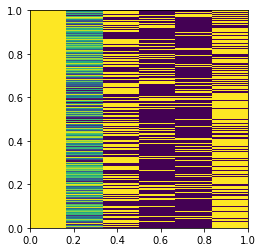

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X1,extent=[0,1,0,1])

# 4. Evaluate how well the model fitting procedure accounts for the variance in the group-level behavioral effects
* For this experiment, the expected behavioral finding is an 3-way interaction between learning condition (SC/SR) and trial type (congruent, incongruent) and stimuli type (freq-inc and rare-inc)

In [16]:
gp_meanRT = pd.read_pickle('gp_meanRT.pkl')
gp_meanRT.head(10)

,bkType,conflictProb,conflict,RT,sbjId
0,SC,rare_Inc,congruent,585.715443,1
1,SC,rare_Inc,incongruent,631.808450,1
2,SC,freq_Inc,congruent,578.896330,1
3,SC,freq_Inc,incongruent,621.245219,1
4,SR,rare_Inc,congruent,564.741262,1
5,SR,rare_Inc,incongruent,629.288301,1
6,SR,freq_Inc,congruent,618.258959,1
7,SR,freq_Inc,incongruent,593.620672,1
8,SC,rare_Inc,congruent,647.556012,3
9,SC,rare_Inc,incongruent,766.827562,3


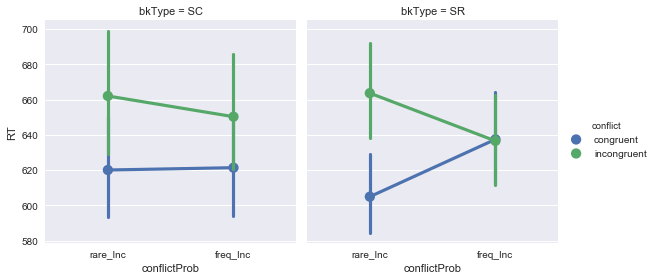

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.factorplot(x='conflictProb',y = 'RT', data=gp_meanRT, hue='conflict',col='bkType')

* The two way interaction can besummarized as one number, what we called an 'ISPC effect' for SC/SR condition

In [18]:
gp_ISPC = pd.read_pickle('gp_ISPC.pkl')
gp_ISPC.head()

,sbjId,SC_ISPC,SR_ISPC,SC_face,SC_name,SR_face,SR_name
0,1,3.744118,89.185327,-0.228430,1.891400,1.383945,5.025075
1,3,47.399978,43.686134,-0.203333,0.288874,1.121236,-0.991767
2,4,20.844006,97.353706,-0.368540,1.410079,-1.054423,4.844151
3,5,13.324552,30.969789,0.798603,0.511450,-0.718272,-0.241946
4,6,-5.709046,61.070809,-0.205837,0.702745,-2.413836,-0.563077


* To test whether subjects indeed relied on 'face' in SC condition to predict conflicts and replied on 'name' in the SR condition, we can perform the following group-level correlation between PE_weights [see step 3. above] and ISPC in SC/SR condition

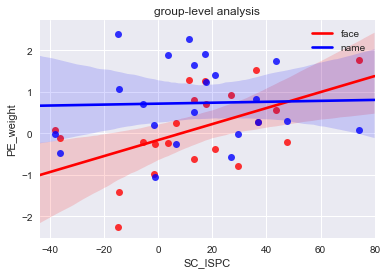

In [19]:
# For the SC condition, we expect subjects to use face to predict trial-by-trial conflict
g = sns.regplot(x = 'SC_ISPC', y = 'SC_face', data = gp_ISPC,color="r")
g = sns.regplot(x = 'SC_ISPC', y = 'SC_name', data = gp_ISPC,color="b")
g.set(xlabel= "SC_ISPC", ylabel= "PE_weight", title= "group-level analysis")
g.legend(['face','name'])
sns.plt.show()

In [20]:
import scipy
SC_face_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SC_ISPC),np.array(gp_ISPC.SC_face))
SC_name_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SC_ISPC),np.array(gp_ISPC.SC_name))
print('For the SC condition:')
print('p-value for correlation between ISPC and PE_face was {:.3f}'.format(SC_face_corr[1]))
print('p-value for correlation between ISPC and PE_name was {:.3f}'.format(SC_name_corr[1]))

For the SC condition:
p-value for correlation between ISPC and PE_face was 0.012
p-value for correlation between ISPC and PE_name was 0.892


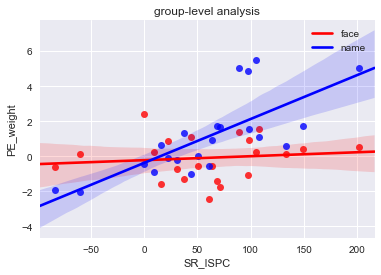

In [21]:
# For the SR condition, we expect subjects to use face to predict trial-by-trial conflict
g = sns.regplot(x = 'SR_ISPC', y = 'SR_face', data = gp_ISPC,color="r")
g = sns.regplot(x = 'SR_ISPC', y = 'SR_name', data = gp_ISPC,color="b")
g.set(xlabel= "SR_ISPC", ylabel= "PE_weight", title= "group-level analysis")
g.legend(['face','name'])
sns.plt.show()

In [22]:
SR_face_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SR_ISPC),np.array(gp_ISPC.SR_face))
SR_name_corr = scipy.stats.pearsonr(np.array(gp_ISPC.SR_ISPC),np.array(gp_ISPC.SR_name))
print('For the SR condition:')
print('p-value for correlation between ISPC and PE_face was {:.3f}'.format(SR_face_corr[1]))
print('p-value for correlation between ISPC and PE_name was {:.3f}'.format(SR_name_corr[1]))

For the SR condition:
p-value for correlation between ISPC and PE_face was 0.595
p-value for correlation between ISPC and PE_name was 0.000
